In [2]:
path = "../input/stanford-dogs-dataset/images/Images/"

In [3]:
import os
len(os.listdir(path))


120

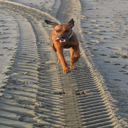

In [4]:
from PIL import Image

im =Image.open('../input/stanford-dogs-dataset/images/Images/n02087394-Rhodesian_ridgeback/n02087394_10238.jpg').resize((128,128))
im

In [5]:
'../input/stanford-dogs-dataset/images/Images/n02087394-Rhodesian_ridgeback'.split('/')[-1].split('-')[-1]

'Rhodesian_ridgeback'

In [6]:
dogs_labels = set()

    
for d in os.listdir(path):
    dogs_labels.add(d)
dogs_labels

{'n02085620-Chihuahua',
 'n02085782-Japanese_spaniel',
 'n02085936-Maltese_dog',
 'n02086079-Pekinese',
 'n02086240-Shih-Tzu',
 'n02086646-Blenheim_spaniel',
 'n02086910-papillon',
 'n02087046-toy_terrier',
 'n02087394-Rhodesian_ridgeback',
 'n02088094-Afghan_hound',
 'n02088238-basset',
 'n02088364-beagle',
 'n02088466-bloodhound',
 'n02088632-bluetick',
 'n02089078-black-and-tan_coonhound',
 'n02089867-Walker_hound',
 'n02089973-English_foxhound',
 'n02090379-redbone',
 'n02090622-borzoi',
 'n02090721-Irish_wolfhound',
 'n02091032-Italian_greyhound',
 'n02091134-whippet',
 'n02091244-Ibizan_hound',
 'n02091467-Norwegian_elkhound',
 'n02091635-otterhound',
 'n02091831-Saluki',
 'n02092002-Scottish_deerhound',
 'n02092339-Weimaraner',
 'n02093256-Staffordshire_bullterrier',
 'n02093428-American_Staffordshire_terrier',
 'n02093647-Bedlington_terrier',
 'n02093754-Border_terrier',
 'n02093859-Kerry_blue_terrier',
 'n02093991-Irish_terrier',
 'n02094114-Norfolk_terrier',
 'n02094258-Norwi

In [6]:
len(dogs_labels)

120

In [12]:
# dogs_labels = list(dogs_labels)
dogs_labels_path = [path + s for s in dogs_labels]

In [ ]:
# dogs_labels_path

In [10]:
import cv2
def load_and_preprocess_image(path):
    image = cv2.imread(path)
    image = cv2.resize(image, (224,224))
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    return image

In [13]:
X = []
y = []

for type_path, label in zip(dogs_labels_path,dogs_labels) :
    for image_path in os.listdir(type_path):
        image = load_and_preprocess_image(type_path+"/"+image_path)
        
        X.append(image)
        y.append(label)

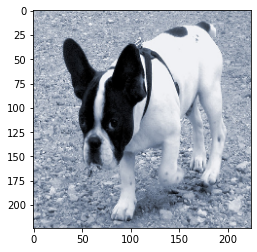

In [14]:
import matplotlib.pyplot as plt
plt.imshow(X[1000])

In [15]:
from sklearn.preprocessing import LabelBinarizer
import numpy as np
encoder = LabelBinarizer()

X = np.array(X)
y = encoder.fit_transform(np.array(y))

In [16]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.4169)

In [17]:
len(X_test)

8580

In [48]:
from keras.preprocessing.image import load_img
from keras.preprocessing.image import img_to_array
import numpy as np

def output(location, new_model):
    img = load_and_preprocess_image(location)
    img = np.expand_dims(img, axis=0)
    answer = new_model.predict(img)
    y_class = answer.argmax(axis = -1)
    
    top_3 = np.argsort(answer[0])[:-4:-1]
    
    y = " ".join(str(x) for x in y_class)
    y = int(y)
    res = dogs_labels[y]
    pred_prob = answer[0][top_3[0]]
    return float(pred_prob),res


In [70]:
import ast
a_file = open("../input/resp-bcnn-codes/Filt_Resp_Dogs_BCNN_with_codes.txt", "r")



string_without_line_breaks = ""
for line in a_file:
    stripped_line = line.rstrip()
    string_without_line_breaks += stripped_line

import re
dict_Classes = ast.literal_eval(re.search('({.+})', string_without_line_breaks).group(0))

# for key, value in dict_Classes.items():
#     print ('classId', key)
#     print ('value', value)
a_file.close()
# print(dict_Classes)

In [51]:
def insert_intermediate_layer_in_keras(model, layer_id, new_layer):
    from keras.models import Model

    layers = [l for l in model.layers]

    x = layers[0].output
    for i in range(1, len(layers)):
        if i == layer_id:
            x = new_layer(x)
        x = layers[i](x)

    model = Model(inputs=layers[0].input, outputs=x) ### inputs instead of input in this version
    return model

In [20]:
from tensorflow.keras.initializers import glorot_normal
from keras.layers import Lambda
import tensorflow
NO_CLASS = 120
def outer_product(x):
    """
    calculate outer-products of 2 tensors

        args 
            x
                list of 2 tensors
                , assuming each of which has shape = (size_minibatch, total_pixels, size_filter)
    """
    return tensorflow.keras.backend.batch_dot(
                x[0]
                , x[1]
                , axes=[1,1]
            ) / x[0].get_shape().as_list()[1] 

def signed_sqrt(x):
    """
    calculate element-wise signed square root

        args
            x
                a tensor
    """
    return tensorflow.keras.backend.sign(x) * tensorflow.keras.backend.sqrt(tensorflow.keras.backend.abs(x) + 1e-9)

def L2_norm(x, axis=-1):
    """
    calculate L2-norm

        args 
            x
                a tensor
    """
    return tensorflow.keras.backend.l2_normalize(x, axis=axis)


def build_model(*tensArry
    ,size_heigth=224
    ,size_width=224
    ,no_class=200
    ,no_last_layer_backbone=17
    
    ,name_optimizer="sgd"
    ,rate_learning=1.0
    ,rate_decay_learning=0.0
    ,rate_decay_weight=0.0
    
    ,name_initializer="glorot_normal"
    ,name_activation_logits="softmax"
    ,name_loss="categorical_crossentropy"
    ,flg_debug=False
    ,**kwargs
):
    
    tensorflow.keras.backend.clear_session()
    
    # print("-------------------------------")
    # print("parameters:")
    # for key, val in locals().items():
    #     if not val == None and not key == "kwargs":
    #         print("\t", key, "=",  val)
    # print("-------------------------------")
    
    ### 
    ### load pre-trained model
    ###
    tensor_input = tensorflow.keras.layers.Input(shape=[size_heigth,size_width,3])
    model_detector = tensorflow.keras.applications.vgg16.VGG16(
                            input_tensor=tensor_input
                            , include_top=False
                            , weights='imagenet'
                        )
    
#     arryWeights_last_After =[]
#     for i in range(512):
#       arryWeights_last_After.append(i)
#     for i in range(512):
#       arryWeights_last_After[i]=1
    
#     arryWeights_last_After[filter_zero]=value_filter
    # print('filter' , filter_zero, "=", arryWeights_last_After[filter_zero])
#     print('tensorArry [0]', tensArry)
    def custom_layer_last(tensor):
        return tensor * tensArry
    lambda_layer = Lambda (custom_layer_last, name="lambda_New")

    model_detector = insert_intermediate_layer_in_keras (model_detector, 18, lambda_layer)
    # print('model detector')
    # model_detector.summary()
    ### 
    ### bi-linear pooling
    ###

    # extract features from detector
    x_detector = model_detector.layers[no_last_layer_backbone].output
    shape_detector = model_detector.layers[no_last_layer_backbone].output_shape
    # if flg_debug:
    #     print("shape_detector : {}".format(shape_detector))

    # extract features from extractor , same with detector for symmetry DxD model
    shape_extractor = shape_detector
    x_extractor = x_detector
    # if flg_debug:
    #     print("shape_extractor : {}".format(shape_extractor))
        
    
    # rehape to (minibatch_size, total_pixels, filter_size)
    x_detector = tensorflow.keras.layers.Reshape(
            [
                shape_detector[1] * shape_detector[2] , shape_detector[-1]
            ]
        )(x_detector)
    # if flg_debug:
    #     print("x_detector shape after rehsape ops : {}".format(x_detector.shape))
        
    x_extractor = tensorflow.keras.layers.Reshape(
            [
                shape_extractor[1] * shape_extractor[2] , shape_extractor[-1]
            ]
        )(x_extractor)
    # if flg_debug:
    #     print("x_extractor shape after rehsape ops : {}".format(x_extractor.shape))
        
        
    # outer products of features, output shape=(minibatch_size, filter_size_detector*filter_size_extractor)
    x = tensorflow.keras.layers.Lambda(outer_product)(
        [x_detector, x_extractor]
    )
    # if flg_debug:
    #     print("x shape after outer products ops : {}".format(x.shape))
        
        
    # rehape to (minibatch_size, filter_size_detector*filter_size_extractor)
    x = tensorflow.keras.layers.Reshape([shape_detector[-1]*shape_extractor[-1]])(x)
    # if flg_debug:
    #     print("x shape after rehsape ops : {}".format(x.shape))
        
        
    # signed square-root 
    x = tensorflow.keras.layers.Lambda(signed_sqrt)(x)
    # if flg_debug:
    #     print("x shape after signed-square-root ops : {}".format(x.shape))
        
    # L2 normalization
    x = tensorflow.keras.layers.Lambda(L2_norm)(x)
    # if flg_debug:
    #     print("x shape after L2-Normalization ops : {}".format(x.shape))



    ### 
    ### attach FC-Layer
    ###

    if name_initializer != None:
            name_initializer = eval(name_initializer+"()")
            
    x = tensorflow.keras.layers.Dense(
            units=no_class
            ,kernel_regularizer=tensorflow.keras.regularizers.l2(rate_decay_weight)
            ,kernel_initializer=name_initializer
        )(x)
    # if flg_debug:
    #     print("x shape after Dense ops : {}".format(x.shape))
    tensor_prediction = tensorflow.keras.layers.Activation(name_activation_logits)(x)
    # if flg_debug:
    #     print("prediction shape : {}".format(tensor_prediction.shape))

        

    ### 
    ### compile model
    ###
    model_bilinear = tensorflow.keras.models.Model(
                        inputs=[tensor_input]
                        , outputs=[tensor_prediction]
                    )
    
    
    # fix pre-trained weights
    for layer in model_detector.layers:
        layer.trainable = False
        
        
    # define optimizers
    opt_adam = tensorflow.keras.optimizers.Adam(
                    lr=rate_learning
                    , decay=rate_decay_learning
                )
    opt_rms = tensorflow.keras.optimizers.RMSprop(
                    lr=rate_learning
                    , decay=rate_decay_learning
                )
    opt_sgd = tensorflow.keras.optimizers.SGD(
                    lr=rate_learning
                    , decay=rate_decay_learning
                    , momentum=0.9
                    , nesterov=False
                )
    optimizers ={
        "adam":opt_adam
        ,"rmsprop":opt_rms
        ,"sgd":opt_sgd
    }
    
    model_bilinear.compile(
        loss=name_loss
        , optimizer=optimizers[name_optimizer]
        , metrics=["categorical_accuracy"]
    )
    
    
    
    # if flg_debug:
    #     model_bilinear.summary()
    
    return model_bilinear

In [59]:
NO_CLASS=120
tensArr=[]
for i in range(512):
    tensArr.append(1)
model = build_model(tensArr,
            # number of output classes, 200 for CUB200
            no_class = NO_CLASS

            # pretrained model specification, using VGG16
            # "block5_conv3 "
            ,no_last_layer_backbone = 18
    
            # training parametes
            ,rate_learning=1.0
            ,rate_decay_weight=1e-8
            ,flg_debug=True
        )

In [60]:
model.load_weights('../input/weights-best/BCNN_dogs_weights_new_last_Best.h5')

In [61]:
layer = model.layers[18]
layer.name

'lambda_New'

In [62]:
dogs_labels = list(dogs_labels)
dogs_labels.sort()

location = "../input/stanford-dogs-dataset/images/Images/n02087394-Rhodesian_ridgeback/n02087394_10238.jpg"
output(location, model)



(0.8077487945556641, 'n02087394-Rhodesian_ridgeback')

In [ ]:
results = model.evaluate(X_test, y_test, verbose=0)
print("test loss, test acc:", results)

**Original model bcnn**

In [ ]:
dogs_labels = list(dogs_labels)
dogs_labels.sort()
# dogs_labels


In [76]:
import cv2
import os
from shutil import copyfile
from pathlib import Path
final_acc = 0
folder = "../input/stanford-dogs-dataset/images/Images/"
# print(len(os.listdir(folder + "001.Black_footed_Albatross")))
imagesFileNames = []
for filename in os.listdir(folder):    
    correct_count_By_folder=0
    print( len(os.listdir(folder+str(filename)) ))
    for img in os.listdir(folder+filename):
        if output(folder+filename+"/"+img, model)[1] ==  filename:
            correct_count_By_folder+=1
    final_accu_by_class = correct_count_By_folder/len(os.listdir(folder+filename))
    print('correctly classified : ' ,filename, correct_count_By_folder)
    print('accuracy for ' , filename , 'is ' , final_accu_by_class)
    final_acc += final_accu_by_class
    print('final_acc : ', final_acc/120) 

#images = load_images_from_folder(folder)


151
correctly classified :  n02091635-otterhound 134
accuracy for  n02091635-otterhound is  0.8874172185430463
final_acc :  0.007395143487858719
159
correctly classified :  n02102318-cocker_spaniel 127
accuracy for  n02102318-cocker_spaniel is  0.7987421383647799
final_acc :  0.014051327974231887
152
correctly classified :  n02101388-Brittany_spaniel 117
accuracy for  n02101388-Brittany_spaniel is  0.7697368421052632
final_acc :  0.020465801658442414
239
correctly classified :  n02088094-Afghan_hound 224
accuracy for  n02088094-Afghan_hound is  0.9372384937238494
final_acc :  0.02827612243947449
252
correctly classified :  n02085936-Maltese_dog 229
accuracy for  n02085936-Maltese_dog is  0.9087301587301587
final_acc :  0.035848873762225814
154
correctly classified :  n02104365-schipperke 141
accuracy for  n02104365-schipperke is  0.9155844155844156
final_acc :  0.043478743892095946
155
correctly classified :  n02100877-Irish_setter 129
accuracy for  n02100877-Irish_setter is  0.8322580

***CauSim*******

In [75]:
import cv2
import os
from shutil import copyfile
from pathlib import Path
import collections

from keras import backend as K

final_acc = 0
folder = "../input/stanford-dogs-dataset/images/Images/"
imagesFileNames = []
for filename in os.listdir(folder):
    for key, value in dict_Classes.items():
        if key == filename: 
          print('key found:', key)
          weights_dic_Conv2_13= {}
          weights_dic_Conv2_13.update(value)
          weights_dic_Conv2_13 = sorted (weights_dic_Conv2_13.items ())
          arryWeights_last_After = []
          od = collections.OrderedDict(weights_dic_Conv2_13)
          for i in range(len(od)):
              if weights_dic_Conv2_13[i][1][0] >0:
                  arryWeights_last_After.append(1) 
              else:
                  arryWeights_last_After.append(0)

          new_model = build_model( arryWeights_last_After
                  # number of output classes, 200 for CUB200
                  ,no_class = NO_CLASS

                  # pretrained model specification, using VGG16
                  # "block5_conv3 "
                  ,no_last_layer_backbone = 18
                              # training parametes
                  ,rate_learning=1.0
                  ,rate_decay_weight=1e-8
                  ,flg_debug=True
              )

                      # now all layers are trainable
          for layer in new_model.layers:
                layer.trainable = True

          # change LR
          opt_sgd = tensorflow.keras.optimizers.SGD(
                          lr=1e-3
                          , decay=1e-9
                          , momentum=0.9
                          , nesterov=False
                      )
          new_model.compile(
              loss="categorical_crossentropy"
              , optimizer=opt_sgd
              , metrics=["categorical_accuracy"]
          )

          new_model.load_weights('../input/weights-best/BCNN_dogs_weights_new_last_Best.h5')

          K.clear_session ()
          break;
    correct_count_By_folder=0
    print( len(os.listdir(folder+str(filename)) ))
    for img in os.listdir(folder+filename):
        if output(folder+filename+"/"+img, new_model)[1] ==  filename:
            correct_count_By_folder+=1
    final_accu_by_class = correct_count_By_folder/len(os.listdir(folder+filename))
    print('correctly classified : ' ,filename, correct_count_By_folder)
    print('accuracy for ' , filename , 'is ' , final_accu_by_class)
    final_acc += final_accu_by_class
    print('final_acc : ', final_acc/120) 


key found: n02091635-otterhound
151
correctly classified :  n02091635-otterhound 151
accuracy for  n02091635-otterhound is  1.0
final_acc :  0.008333333333333333
key found: n02102318-cocker_spaniel
159
correctly classified :  n02102318-cocker_spaniel 159
accuracy for  n02102318-cocker_spaniel is  1.0
final_acc :  0.016666666666666666
key found: n02101388-Brittany_spaniel
152
correctly classified :  n02101388-Brittany_spaniel 152
accuracy for  n02101388-Brittany_spaniel is  1.0
final_acc :  0.025
key found: n02088094-Afghan_hound
239
correctly classified :  n02088094-Afghan_hound 239
accuracy for  n02088094-Afghan_hound is  1.0
final_acc :  0.03333333333333333
key found: n02085936-Maltese_dog
252
correctly classified :  n02085936-Maltese_dog 252
accuracy for  n02085936-Maltese_dog is  1.0
final_acc :  0.041666666666666664
key found: n02104365-schipperke
154
correctly classified :  n02104365-schipperke 154
accuracy for  n02104365-schipperke is  1.0
final_acc :  0.05
key found: n02100877-